In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader  # veri yüklemek için
import torchvision.utils as utils  ##görselleştirme için
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision


In [67]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CancerOnlyDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Tek kanal için "L"
        if self.transform:
            image = self.transform(image)
        label = 1  # Tüm görüntüler kanserli olduğu için etiket 1
        return image, label


In [68]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),  # X-ray’ler genelde tek kanallı
    transforms.ToTensor(),                # [0, 255] → [0, 1]
    transforms.Normalize([0.5], [0.5])    # [0, 1] → [-1, 1]
])


In [70]:
image_size=256*256

In [71]:
dataset_path="/content/drive/MyDrive/Colab Notebooks/train/Cancer"

In [72]:
len(train_Datasets)

803

In [73]:
train_Datasets=CancerOnlyDataset(image_dir=dataset_path, transform=transform)

In [74]:
dataloader=DataLoader(train_Datasets,batch_size=8,shuffle=True)

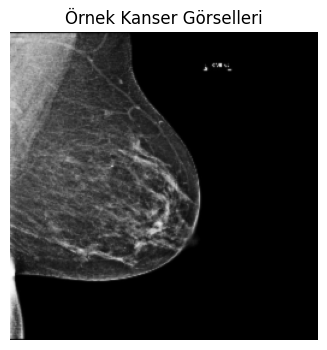

In [76]:
import matplotlib.pyplot as plt

# İlk batch'ten birkaç görsel gösterelim
images, labels = next(iter(dataloader))
grid_img = torchvision.utils.make_grid(images[:1], nrow=1, normalize=True)
plt.figure(figsize=(8, 4))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title("Örnek Kanser Görselleri")
plt.show()


In [77]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),     # 256 → 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),   # 128 → 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 64 → 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # 8 → 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 1, kernel_size=4),             # 4 → 1
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        return out.view(-1, 1)


In [78]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512 * 4 * 4),     # Başlangıç: 4x4
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4 → 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8 → 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16 → 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 32 → 64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 64 → 128
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 1, 4, 2, 1),     # 128 → 256
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [82]:

lr=0.0001
epochs=200
generator=Generator().to(device)
discriminatör=Discriminator().to(device)

criterion=nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminatör.parameters(), lr=0.00005, betas=(0.5, 0.999))


In [85]:
import os
import torch
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Klasör oluştur
os.makedirs("/content/drive/MyDrive/augfinally_ssim", exist_ok=True)

# SSIM hesaplama fonksiyonu
def calculate_ssim(img1, img2):
    img1 = to_pil_image(img1)
    img2 = to_pil_image(img2)
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, data_range=img2.max() - img2.min())

g_loss_list = []
d_loss_list = []
epoch_ssim_scores = []

for epoch in range(epochs):
    for i, (real_img, _) in enumerate(dataloader):
        real_img = real_img.to(device)
        batch_size = real_img.size(0)

        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        noise = torch.randn(batch_size, 100).to(device)
        fake_img = generator(noise)

        # Discriminator
        real_loss = criterion(discriminatör(real_img), real_labels)
        fake_loss = criterion(discriminatör(fake_img.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator
        g_loss = criterion(discriminatör(fake_img), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    d_loss_list.append(d_loss.item())
    g_loss_list.append(g_loss.item())

    # === SSIM hesapla ===
    with torch.no_grad():
        test_noise = torch.randn(1, 100).to(device)
        fake_images = generator(test_noise).cpu()

        # Gerçek görüntülerden örnek al
        real_images_sample = next(iter(dataloader))[0][:len(fake_images)].cpu()

        # Ortak sayıda görüntü için SSIM
        num_compare = min(len(fake_images), len(real_images_sample))
        ssim_scores = [
            calculate_ssim(fake_images[i], real_images_sample[i])
            for i in range(num_compare)
        ]
        mean_ssim = sum(ssim_scores) / len(ssim_scores)
        epoch_ssim_scores.append((epoch + 1, mean_ssim))

    print(f"Epoch {epoch+1}/{epochs} | d_loss: {d_loss.item():.3f} | g_loss: {g_loss.item():.3f} | SSIM: {mean_ssim:.4f}")

# ✅ En yüksek SSIM'e sahip epoch'u bul
best_epoch, best_ssim = sorted(epoch_ssim_scores, key=lambda x: x[1], reverse=True)[0]
print(f"\n✅ En yüksek SSIM skoru {best_ssim:.4f} ile epoch {best_epoch}")

# ✅ En iyi epoch için sahte görüntü üret ve kaydet
with torch.no_grad():
    best_noise = torch.randn(50, 100).to(device)
    best_fake_images = generator(best_noise).cpu()

    best_dir = os.path.join("/content/drive/MyDrive/augfinally_ssim", f"epoch_{best_epoch}")
    os.makedirs(best_dir, exist_ok=True)

    for idx, img in enumerate(best_fake_images):
        save_path = os.path.join(best_dir, f"img_{idx+1:02d}.jpg")
        save_image(img, save_path, normalize=True)

    print(f">>> En iyi epoch ({best_epoch}) için 50 sahte görüntü '{best_dir}' klasörüne kaydedildi.")


Epoch 1/200 | d_loss: 0.352 | g_loss: 4.442 | SSIM: 0.2135
Epoch 2/200 | d_loss: 0.703 | g_loss: 1.689 | SSIM: 0.2453
Epoch 3/200 | d_loss: 2.765 | g_loss: 1.604 | SSIM: 0.2771
Epoch 4/200 | d_loss: 0.455 | g_loss: 2.143 | SSIM: 0.2152
Epoch 5/200 | d_loss: 2.215 | g_loss: 1.342 | SSIM: 0.2421
Epoch 6/200 | d_loss: 1.248 | g_loss: 1.774 | SSIM: 0.3252
Epoch 7/200 | d_loss: 1.943 | g_loss: 1.069 | SSIM: 0.1250
Epoch 8/200 | d_loss: 2.525 | g_loss: 1.634 | SSIM: 0.1271
Epoch 9/200 | d_loss: 0.491 | g_loss: 4.436 | SSIM: 0.3744
Epoch 10/200 | d_loss: 0.394 | g_loss: 5.104 | SSIM: 0.3646
Epoch 11/200 | d_loss: 0.380 | g_loss: 3.566 | SSIM: 0.0161
Epoch 12/200 | d_loss: 0.449 | g_loss: 3.186 | SSIM: 0.0578
Epoch 13/200 | d_loss: 0.553 | g_loss: 3.147 | SSIM: 0.3380
Epoch 14/200 | d_loss: 1.034 | g_loss: 3.357 | SSIM: 0.0808
Epoch 15/200 | d_loss: 0.543 | g_loss: 3.236 | SSIM: 0.1227
Epoch 16/200 | d_loss: 0.425 | g_loss: 3.443 | SSIM: 0.3354
Epoch 17/200 | d_loss: 0.419 | g_loss: 3.283 | SS

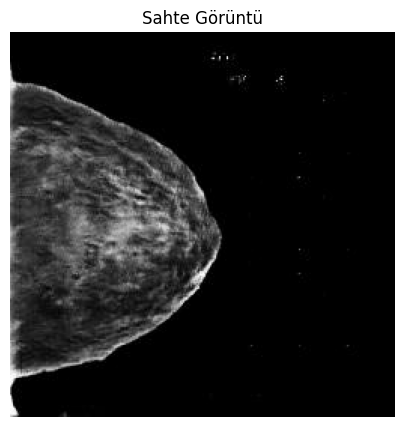

In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image_path = "/content/drive/MyDrive/augfinally_ssim/epoch_175/img_01.jpg"


img = mpimg.imread(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Sahte Görüntü")
plt.show()

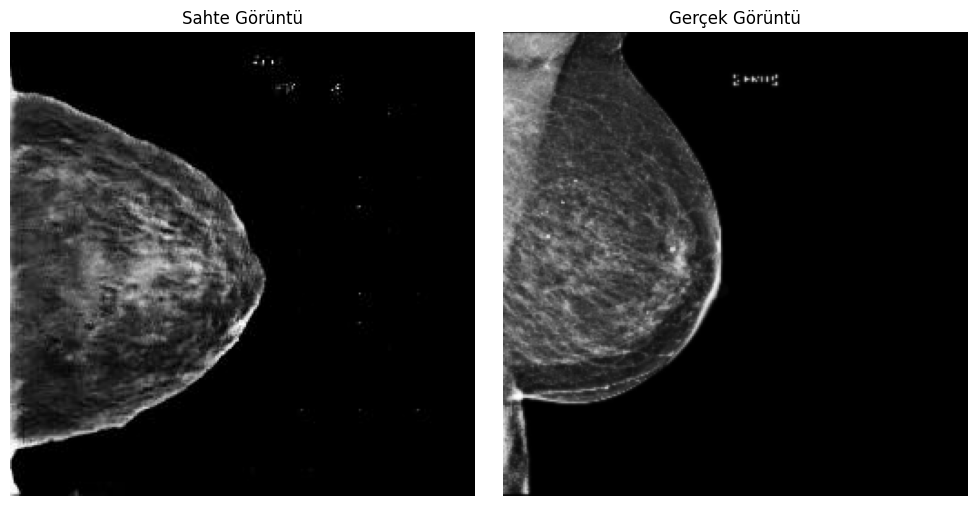

In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision

# 1. Görsel: Sahte görüntü
fake_img_path = "/content/drive/MyDrive/augfinally_ssim/epoch_175/img_01.jpg"
fake_img = mpimg.imread(fake_img_path)

#  2. Görsel: Gerçek veri kümesinden gelen örnek
images, labels = next(iter(dataloader))
real_img = torchvision.utils.make_grid(images[2:3], nrow=1, normalize=True).permute(1, 2, 0)

# Görselleri yan yana çiz
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(fake_img, cmap='gray')
plt.title("Sahte Görüntü")
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(real_img)
plt.title("Gerçek Görüntü")
plt.axis('off')

plt.tight_layout()
plt.show()
